<a href="https://colab.research.google.com/github/freddy120/svmtp2/blob/main/TP2_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabajo Practico Nro 2 - SVM
autor: Freddy Rodrigo Mendoza Ticona

In [6]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display


%matplotlib inline

display.clear_output()



In [7]:
X_train = []
y_train = []
with open("train.csv", 'r') as f:
  f.readline()
  for i in f.readlines():
    X_train.append([float(i.split(',')[1]),  float(i.split(',')[2])])
    y_train.append(float(i.split(',')[3]))


In [8]:
X_test = []
y_test = []
with open("test.csv", 'r') as f:
  f.readline()
  for i in f.readlines():
    X_test.append([float(i.split(',')[1]),  float(i.split(',')[2])])
    y_test.append(float(i.split(',')[3]))


### Gradiente descendente

Sea la funcion de costo que queremos minimizar, necesitamos calcular su gradiente
$$
J(w,b) = \frac{1}{2} \lVert w \rVert^2 + C\sum_{i=1}^{n}max\{0,1-y_{i}(w^Tx_{i}+b)\}
$$

que es igual a: 
\begin{equation}
J(w,b) = \frac{1}{2} \lVert w \rVert^2 + C\sum_{i=1}^{n}\ell(t)
\end{equation}
donde:
$$
\ell(t) = max\{0, 1 − t\} 
$$
y 

\begin{equation}
t = y_{i}(w^Tx_{i}+b)
\end{equation}

\begin{equation}
\frac{d\ell}{dt}=\left\lbrace\begin{array}{c} -1 \ \ \ t < 1
\\ 0 \ \ \ t \geq 1 \end{array}\right.
\end{equation}

aplicamos regla de la cadena para calcular el gradiente:
\begin{equation}
\frac{\partial\ell}{\partial w}=\frac{\partial\ell}{\partial t}\frac{\partial t}{\partial w} = \left\lbrace\begin{array}{c} -y_{i}x_{i} \ \ \ y_{i}(w^Tx_{i}+b)<1
\\ 0 \ \ \ y_{i}(w^Tx_{i}+b) \geq 1 \end{array}\right.
\end{equation}

y

\begin{equation}
\frac{\partial\ell}{\partial b}=\frac{\partial\ell}{\partial t}\frac{\partial t}{\partial b} = \left\lbrace\begin{array}{c} -y_{i} \ \ \ y_{i}(w^Tx_{i}+b)<1
\\ 0 \ \ \ y_{i}(w^Tx_{i}+b) \geq 1 \end{array}\right.
\end{equation}

Entonces:
\begin{equation}
\frac{\partial J}{\partial w} = \left\lbrace\begin{array}{c} w - C\sum_{i=1}^{n}y_{i}x_{i} \ \ \ y_{i}(w^Tx_{i}+b)<1
\\ w \ \ \ y_{i}(w^Tx_{i}+b) \geq 1 \end{array}\right.
\end{equation}

y 

\begin{equation}
\frac{\partial J}{\partial b} = \left\lbrace\begin{array}{c} -C\sum_{i=1}^{n}y_{i} \ \ \ y_{i}(w^Tx_{i}+b)<1
\\ 0 \ \ \ y_{i}(w^Tx_{i}+b) \geq 1 \end{array}\right.
\end{equation}


In [237]:
## basado en https://github.com/chZzZzZz/gradientdecent

class SvmGrad:
    def __init__(self, X, y, W=None, b=None, type='BGD',batch_size=64, alpha=0.1, epsilon=0.1, C=0.003, epoch=100):
      self.X = np.array(X)
      self.y = np.array(y)
      self.alpha = alpha # learning rate
      self.epsilon = epsilon
      self.C = C
      self.col = self.X.shape[1] #the number of columns of data
      self.m = self.X.shape[0] #the number of rows of data
      #self.W = np.ones((self.col, 1)) #init values
      #self.b = np.ones(1) # init values
      self.W = W #init values
      self.b = b
      self.grad = np.ones((self.col + 1, 1))
      self.epoch = epoch
      self.type = type
      self.batch_size = batch_size

    def update_hyperparams(self):
      self.W = self.W - self.alpha * self.grad[0:2]
      self.b = self.b - self.alpha * self.grad[2] 
      return self.W, self.b

    def compute_loss(self): # compute J
        sumatoria = np.sum(np.amax(np.hstack((np.zeros((self.m,1)), (1 - self.y*(np.dot(self.W.T, self.X.T) + self.b)).T)), axis=1))
        return 1/2*np.dot(self.W.T, self.W) + self.C*sumatoria

    def compute_grad(self):
      if self.type == 'BGD':
        sum_part_w = [0,0]
        sum_part_b = 0
        for i in range(self.m):
          if self.y[i]*(np.dot(self.W.T, self.X[i]) + self.b)[0] < 1:
            sum_part_w += self.y[i]*self.X[i]
            sum_part_b += self.y[i]
          
        
        grad_w = self.W - self.C*np.array([sum_part_w]).T
        grad_b = -self.C*sum_part_b
      
        self.grad = np.vstack((grad_w,grad_b))

      elif self.type == 'SGD':
        r = np.random.randint(self.m)
        sum_part_w = [0,0]
        sum_part_b = 0
        X_batch = self.X[r,:]
        y_batch = self.y[r]
        
        if y_batch*(np.dot(self.W.T, X_batch) + self.b)[0] < 1:
            sum_part_w += y_batch*X_batch
            sum_part_b += y_batch
        
        grad_w = self.W - self.C*np.array([sum_part_w]).T
        grad_b = -self.C*sum_part_b
      
        self.grad = np.vstack((grad_w,grad_b))

      elif self.type == 'MINI':
        r = np.random.choice(self.m, self.batch_size, replace=False)
        sum_part_w = [0,0]
        sum_part_b = 0
        X_batch = self.X[r,:]
        y_batch = self.y[r]
        for i in range(self.batch_size):
          if y_batch[i]*(np.dot(self.W.T, X_batch[i]) + self.b)[0] < 1:
            sum_part_w += y_batch[i]*X_batch[i]
            sum_part_b += y_batch[i]
          
        
        grad_w = self.W - self.C * np.array([sum_part_w]).T
        grad_b = -self.C * sum_part_b
      
        self.grad = np.vstack((grad_w,grad_b))
      else:
          print("NO such gradient dencent Method!")
      return self.grad

    def run(self):
      self.grad = self.compute_grad()
      loss = self.compute_loss()
      self.W, self.b = self.update_hyperparams()
      loss_new = self.compute_loss()
      i = 1
      print('Round {} Diff Loss: {}'.format(i, np.abs(loss_new-loss)[0][0]))
      history = [[1], [loss_new[0][0]]]

      while np.abs(loss_new - loss)> self.epsilon:
          self.grad = self.compute_grad()
          self.W, self.b = self.update_hyperparams()
          if self.type == 'BGD':
              loss = loss_new
              loss_new = self.compute_loss()
          else:
              if i % self.epoch == 0:
                  loss = loss_new
                  loss_new = self.compute_loss()
          i += 1
          history[0].append(i)
          history[1].append(loss_new[0][0])
          print('Round {} Diff Loss: {}'.format(i, np.abs(loss_new-loss)[0][0]))
      best_hyperparam = self.W, self.b
      return history, best_hyperparam

    def plot_loss(self,history):
        fig = plt.figure(figsize=(8, 6))
        plt.plot(history[0], history[1])
        plt.xlabel('Number of iterations')
        plt.ylabel('Loss')
        plt.title([self.type][0])
        plt.show()


def plot_train_points(X, Y, W, b):
  x1 = np.linspace(min(X[:,0]), max(X[:,0]), 1000)
  x2 = -W[0]/W[1]*x1 - b/W[1]
  plt.plot(x1, x2)
  plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired,
            edgecolor='black', s=20)
  plt.title("HyperPlano en X")
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.show()



##  Batch Gradient Descent (BGD)

In [268]:
start_w = np.array([[0.2], [0.3]])
start_b = np.array([0.1])
lr = 0.01
epsilon = 0.5e-3
C = 0.7
epoch = 1
svmClassifier = SvmGrad(X_train, y_train, W=start_w, b=start_b, type='BGD',alpha=lr, epsilon=epsilon, C=C, epoch=epoch)
history,best_hyperparam = svmClassifier.run()

Round 1 Diff Loss: 42.078663693747146
Round 2 Diff Loss: 4.393561315809421
Round 3 Diff Loss: 3.199866341143178
Round 4 Diff Loss: 1.7700887221824857
Round 5 Diff Loss: 0.8965518496431457
Round 6 Diff Loss: 0.633730332022381
Round 7 Diff Loss: 0.4273537796357658
Round 8 Diff Loss: 0.28750534431225816
Round 9 Diff Loss: 0.21530414885773297
Round 10 Diff Loss: 0.1747389773315433
Round 11 Diff Loss: 0.11255304628539875
Round 12 Diff Loss: 0.12073008637082694
Round 13 Diff Loss: 0.07439689884884615
Round 14 Diff Loss: 0.05661811669748573
Round 15 Diff Loss: 0.018485233212793162
Round 16 Diff Loss: 0.013952988602731864
Round 17 Diff Loss: 0.01910752043495023
Round 18 Diff Loss: 0.018727280778286115
Round 19 Diff Loss: 0.01353357622320317
Round 20 Diff Loss: 0.016219295011545398
Round 21 Diff Loss: 0.017452738972117743
Round 22 Diff Loss: 0.011024112829566945
Round 23 Diff Loss: 0.003590356913818482
Round 24 Diff Loss: 0.016500461088639895
Round 25 Diff Loss: 0.021314259616474374
Round 26 Di

Best:  W = [1.09266089 1.14298299], b = [0.492]


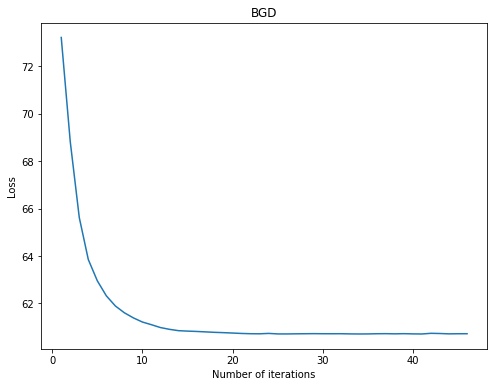

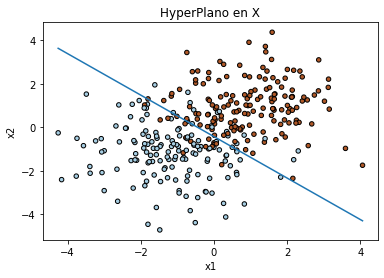

In [269]:
print("Best:  W = {}, b = {}".format(best_hyperparam[0][:,0], best_hyperparam[1]))
svmClassifier.plot_loss(history)
plot_train_points(np.array(X_train), np.array(y_train), best_hyperparam[0], best_hyperparam[1])

### Performance


In [270]:
### Performance
Xtest = np.array(X_test)
ytest = np.array(y_test)
yresult = np.sign(np.dot(best_hyperparam[0].T, Xtest.T) + best_hyperparam[1])[0]
print("Classifier Accurary = {}".format(np.sum(ytest == yresult)/len(ytest)))

Classifier Accurary = 0.925


##  Stochastic Gradient Descent (SGD)

In [306]:
start_w = np.array([[1], [1]])
start_b = np.array([1])
lr = 0.1
epsilon = 1e-3
C = 0.7
epoch = 1
svmClassifier = SvmGrad(X_train, y_train, W=start_w, b=start_b, type='SGD',alpha=lr, epsilon=epsilon, C=C, epoch=epoch)
history,best_hyperparam = svmClassifier.run()

Round 1 Diff Loss: 3.005935087603646
Round 2 Diff Loss: 0.40284292347061523
Round 3 Diff Loss: 3.8222061430270315
Round 4 Diff Loss: 4.866938791806277
Round 5 Diff Loss: 17.721259822889138
Round 6 Diff Loss: 0.5872191889340996
Round 7 Diff Loss: 7.579834025887081
Round 8 Diff Loss: 8.240811250749942
Round 9 Diff Loss: 7.521841772933257
Round 10 Diff Loss: 6.461543812500722
Round 11 Diff Loss: 14.554396391112178
Round 12 Diff Loss: 11.98743131479128
Round 13 Diff Loss: 7.289446419669574
Round 14 Diff Loss: 7.344006707252845
Round 15 Diff Loss: 7.348177766529673
Round 16 Diff Loss: 7.112618381997379
Round 17 Diff Loss: 16.98782598969069
Round 18 Diff Loss: 7.270958341259558
Round 19 Diff Loss: 7.121329594996453
Round 20 Diff Loss: 23.839703536389237
Round 21 Diff Loss: 7.549638238265317
Round 22 Diff Loss: 6.555278676198014
Round 23 Diff Loss: 4.091468513751906
Round 24 Diff Loss: 6.800138327889513
Round 25 Diff Loss: 6.953096030619307
Round 26 Diff Loss: 6.970237190425308
Round 27 Diff 

Best:  W = [0.34945833 0.32019104], b = [0.02]


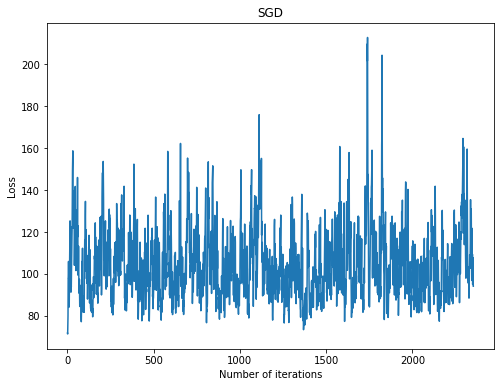

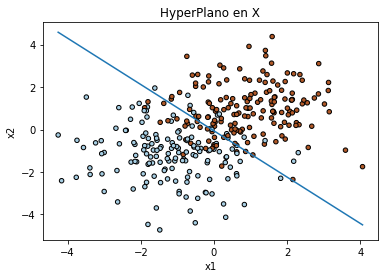

In [307]:
print("Best:  W = {}, b = {}".format(best_hyperparam[0][:,0], best_hyperparam[1]))
svmClassifier.plot_loss(history)
plot_train_points(np.array(X_train), np.array(y_train), best_hyperparam[0], best_hyperparam[1])

### Performance


In [273]:
### Performance
Xtest = np.array(X_test)
ytest = np.array(y_test)
yresult = np.sign(np.dot(best_hyperparam[0].T, Xtest.T) + best_hyperparam[1])[0]
print("Classifier Accurary = {}".format(np.sum(ytest == yresult)/len(ytest)))

Classifier Accurary = 0.925


## Mini-batch Gradient Descent 

In [298]:
start_w = np.array([[0.2], [0.3]])
start_b = np.array([0.1])
lr = 0.01
epsilon = 0.5e-3
C = 0.7
epoch = 1
svmClassifier = SvmGrad(X_train, y_train, W=start_w, b=start_b, type='MINI', batch_size=100,alpha=lr, epsilon=epsilon, C=C, epoch=epoch)
history,best_hyperparam = svmClassifier.run()

Round 1 Diff Loss: 47.4823052353202
Round 2 Diff Loss: 0.9332551061141601
Round 3 Diff Loss: 1.6113928267654671
Round 4 Diff Loss: 0.7980926125564878
Round 5 Diff Loss: 0.026738408366270505
Round 6 Diff Loss: 0.010299759875280756
Round 7 Diff Loss: 0.25888852798125583
Round 8 Diff Loss: 0.3760086228025088
Round 9 Diff Loss: 0.8175488597232885
Round 10 Diff Loss: 0.4807437137513162
Round 11 Diff Loss: 0.4903722264277235
Round 12 Diff Loss: 0.6915808604569165
Round 13 Diff Loss: 0.003024230171376985
Round 14 Diff Loss: 0.4533590684014399
Round 15 Diff Loss: 0.1559445956397667
Round 16 Diff Loss: 0.14091660440915632
Round 17 Diff Loss: 0.00037924176595538484


Best:  W = [0.95261229 0.89396809], b = [0.261]


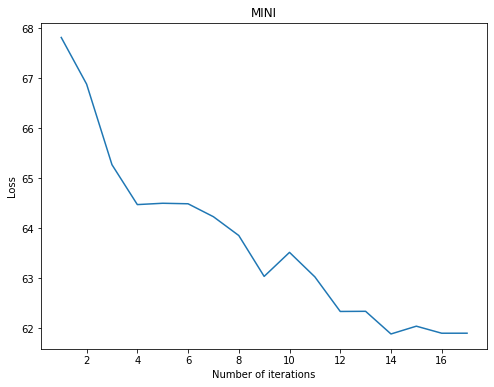

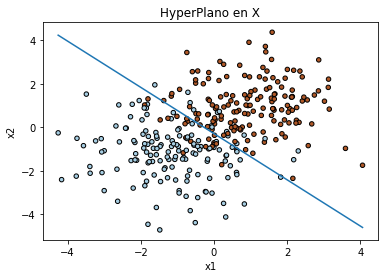

In [299]:
print("Best:  W = {}, b = {}".format(best_hyperparam[0][:,0], best_hyperparam[1]))
svmClassifier.plot_loss(history)
plot_train_points(np.array(X_train), np.array(y_train), best_hyperparam[0], best_hyperparam[1])

### Performance

In [300]:
### Performance
Xtest = np.array(X_test)
ytest = np.array(y_test)
yresult = np.sign(np.dot(best_hyperparam[0].T, Xtest.T) + best_hyperparam[1])[0]
print("Classifier Accurary = {}".format(np.sum(ytest == yresult)/len(ytest)))

Classifier Accurary = 0.95


## Usando SkLearn

In [301]:
Xtrain = np.array(X_train)
ytrain = np.array(y_train)
Xtest =  np.array(X_test)
ytest =  np.array(y_test)

svm = SVC(C=C, kernel='linear', tol=epsilon) 
svm.fit(Xtrain, ytrain) 


SVC(C=0.7, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.0005, verbose=False)

In [121]:
#print(svm.support_vectors_) 

In [302]:
print(svm.support_)
print(svm.coef_.T)
print(svm.intercept_)


[  0   5   9  14  23  27  29  30  52  54  69  71  75  77  96 107 117 118
 164 166 174 180 181 185 199 202 218 247 248 249 254 257 259 261 266 278
 280 281 290 291 295 303 306 310 316   2  31  34  35  45  59  64  67  76
  79  92  99 104 111 120 129 132 135 138 159 184 190 194 201 204 205 207
 222 225 228 237 240 241 244 252 258 274 283 287 293 297 302 309 315 319]
[[1.10118234]
 [1.14649773]]
[0.48741393]


In [303]:
print("Best (SVM):  W = {}, b = {}".format(svm.coef_[0], svm.intercept_))

Best (SVM):  W = [1.10118234 1.14649773], b = [0.48741393]


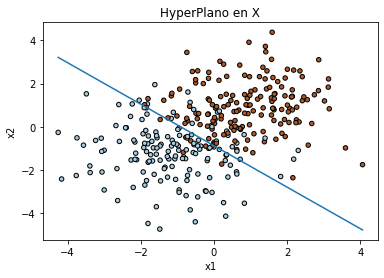

In [304]:
plot_train_points(np.array(X_train), np.array(y_train), svm.coef_.T, b)

## Performance


In [305]:
print("SVM Classifier Accurary = {}".format(np.sum(svm.predict(Xtest) == ytest)/len(ytest)))


SVM Classifier Accurary = 0.925
